In [1]:
import numpy as np
import pandas as pd
from feature_selector import FeatureSelector
from matplotlib import pyplot as plt
import seaborn as sns 
from tqdm import tqdm_notebook, tqdm_pandas
from tqdm.autonotebook import tqdm

pd.options.display.float_format = '{:.2f}'.format
tqdm.pandas()
%matplotlib inline 
sns.set()
%config InlineBackend.figure_format = 'retina'

/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
df = pd.read_csv('ds_homework_sample.csv', sep='|')
df.head()

,date_time,banner_id,advertiser_id,offer_id,zone_id,affiliate_id,geo,region_code,city_code,varp,...,browser,lang,varpp,varcc,isp,mobile_isp,proxy,netspeed,impressions,conversions
0,2016-09-09 10:00:00,23051597.00,502713.00,492.00,4375553.00,2505762.00,BR,726.00,4162.00,4.00,...,fb,pt,1.00,0.00,17111.00,0.00,f,BROADBAND,1.00,0.00
1,2016-09-05 14:00:00,23075994.00,8508.00,2287.00,13732852.00,6530828.00,RO,12074.00,512299.00,1.00,...,chrome,ro,2.00,0.00,88118.00,0.00,f,BROADBAND,1.00,0.00
2,2016-09-08 22:00:00,21359300.00,17528.00,nan,12242731.00,5797966.00,EG,25295.00,29514.00,4.00,...,chrome,en,6.00,0.00,102851.00,0.00,f,BROADBAND,1.00,0.00
3,2016-09-10 19:00:00,23074678.00,420481.00,2287.00,5388033.00,62457.00,JO,25649.00,12381.00,1.00,...,ie,en,2.00,0.00,105638.00,0.00,f,BROADBAND,1.00,0.00
4,2016-09-14 00:00:00,22289011.00,450621.00,nan,11164447.00,3927.00,BR,10122.00,11105.00,1.00,...,chrome,pt,2.00,0.00,104045.00,0.00,f,BROADBAND,1.00,0.00


In [3]:
# last row is incorrect
df.tail(2)

,date_time,banner_id,advertiser_id,offer_id,zone_id,affiliate_id,geo,region_code,city_code,varp,...,browser,lang,varpp,varcc,isp,mobile_isp,proxy,netspeed,impressions,conversions
999999,2016-09-11 08:00:00,20522087.00,368197.00,nan,13014907.00,25560.00,PL,14360.00,42626.00,1.00,...,firefox,pl,1.00,0.00,35105.00,0.00,f,BROADBAND,1.00,0.00
1000000,(1000000 rows),nan,nan,nan,nan,nan,NaN,nan,nan,nan,...,NaN,NaN,nan,nan,nan,nan,NaN,NaN,nan,nan


In [4]:
df.drop(1e6, inplace=True)

### Категориальные признаки 
Список категориальных признаков без допуска N/A - значений, так как эти данные либо являются метаданными для рекламодателя/баннера или сайта/месторасположения:
  * zone_id
  * affilate_id
  * banner_id
  * advertiser_id
  * offer_id </br>
  ---
Список категориальных признаков, допускающие N/A - значения:
  * geo
  * region_code
  * city_code
  * os_type
  * os
  * os_version
  * device_type
  * device
  * browser
  * netspeed 
  * lang
  * isp
  * mobile_isp </br>
  ---
Список количественных признаков:
  * vapp
  * varpp
  * varcc </br>
  ---
Список индикаторов (булевы) признаки: 
  * proxy
---
### Что можно применить для отбора признаков: 
    1) Человеческая логика
    2) Итеративные признаки - не жадные (например полного перебора), жадные (add-del)
    3) На основе модели - Lasso-регрессия, feature_importance в деревяных методах.
    4) Сравнить две модели(с фичами и без) при помощи wilcoxon.
Так как категориальным признакам суждено быть повернутыми в OHE, то большинство вариантов отпадает, из-за слишком разреженной матрицы признаков, которые не поместятся в память. Для этого задания, например, последовательно были использованы два локальных компьютера с 4 и 16 ГБ оперативной памяти и инстанс на Google Cloud на 52 ГБ в дальнейшем.
      
Что заранее можно сказать о признаках:

   * Второй список категориальных признаков можно описать обобщенно как __"профиль" пользователя__ - набор некоторых характеристик, присущих конкретному человеку, которому показывается реклама.
   * Первый набор, аналогично, частично определяет "профиль" для рекламы, но не так очевидно, как это делает второй набор.
 
_Ходы решения_:
Для отбора признаков деревяным методом используем модуль feature-selector, которая внедряет ```feature_importances``` из _LightGBM_, так же из популярных решений - _BorutaPy_. Количественные признаки проверим при помощи F-критерия. Признаки с малым вкладом дополнительно оценим при помощи ```scipy.stats.wilcoxon```.

In [5]:
# 1st group categorical 
categorical_without_nans = df.columns[1:6]
categorical_without_nans

Index(['banner_id', 'advertiser_id', 'offer_id', 'zone_id', 'affiliate_id'], dtype='object')

In [6]:
# 2st group categorical 
categorical_with_nans = pd.Index(['geo', 'region_code', 'city_code', 'os_type', 'os', \
                                  'os_version', 'device_type', 'device', 'browser', 'lang', \
                                  'isp', 'mobile_isp', 'netspeed'])
categorical_with_nans

Index(['geo', 'region_code', 'city_code', 'os_type', 'os', 'os_version',
       'device_type', 'device', 'browser', 'lang', 'isp', 'mobile_isp',
       'netspeed'],
      dtype='object')

In [7]:
# map to bool type
proxy_mapping = {'f': 0, 't': 1}

df['proxy'] = df['proxy'].map(proxy_mapping)

In [8]:
df[categorical_with_nans] = df[categorical_with_nans].astype(object)
df[categorical_without_nans] = df[categorical_without_nans].astype(object)
# df['date_time'] = df['date_time'].progress_apply(pd.to_datetime)

df.head()

,date_time,banner_id,advertiser_id,offer_id,zone_id,affiliate_id,geo,region_code,city_code,varp,...,browser,lang,varpp,varcc,isp,mobile_isp,proxy,netspeed,impressions,conversions
0,2016-09-09 10:00:00,23051597.00,502713.00,492.00,4375553.00,2505762.00,BR,726.00,4162.00,4.00,...,fb,pt,1.00,0.00,17111.00,0.00,0,BROADBAND,1.00,0.00
1,2016-09-05 14:00:00,23075994.00,8508.00,2287.00,13732852.00,6530828.00,RO,12074.00,512299.00,1.00,...,chrome,ro,2.00,0.00,88118.00,0.00,0,BROADBAND,1.00,0.00
2,2016-09-08 22:00:00,21359300.00,17528.00,NaN,12242731.00,5797966.00,EG,25295.00,29514.00,4.00,...,chrome,en,6.00,0.00,102851.00,0.00,0,BROADBAND,1.00,0.00
3,2016-09-10 19:00:00,23074678.00,420481.00,2287.00,5388033.00,62457.00,JO,25649.00,12381.00,1.00,...,ie,en,2.00,0.00,105638.00,0.00,0,BROADBAND,1.00,0.00
4,2016-09-14 00:00:00,22289011.00,450621.00,NaN,11164447.00,3927.00,BR,10122.00,11105.00,1.00,...,chrome,pt,2.00,0.00,104045.00,0.00,0,BROADBAND,1.00,0.00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 25 columns):
date_time        1000000 non-null object
banner_id        1000000 non-null object
advertiser_id    1000000 non-null object
offer_id         392841 non-null object
zone_id          1000000 non-null object
affiliate_id     1000000 non-null object
geo              999926 non-null object
region_code      1000000 non-null object
city_code        1000000 non-null object
varp             1000000 non-null float64
os_type          1000000 non-null object
os               1000000 non-null object
os_version       1000000 non-null object
device_type      1000000 non-null object
device           1000000 non-null object
browser          1000000 non-null object
lang             1000000 non-null object
varpp            1000000 non-null float64
varcc            1000000 non-null float64
isp              1000000 non-null object
mobile_isp       1000000 non-null object
proxy            1000000 n

Предварительно можно заключить, что признак *offer_id* является не слишком полезным из-за большого количества пропусков.

In [370]:
df[['varp', 'varpp', 'varcc']].describe()

,varp,varpp,varcc
count,1000000.00000,1000000.00000,1000000.00000
mean,2.27599,7.40299,3.36231
std,1.42884,35.71248,21.13040
min,0.00000,0.00000,0.00000
25%,1.00000,1.00000,0.00000
50%,1.00000,2.00000,0.00000
75%,4.00000,5.00000,1.00000
max,5.00000,6772.00000,1644.00000


In [372]:
df.groupby('varp')['conversions'].value_counts()

varp     conversions
0.00000  0.00000         18320
         1.00000            14
1.00000  0.00000        494288
         1.00000          1679
         2.00000            10
         3.00000             6
         7.00000             1
2.00000  0.00000         37944
         1.00000            83
3.00000  0.00000         95390
         1.00000           176
         2.00000             3
         6.00000             1
4.00000  0.00000        342002
         1.00000          1163
         2.00000            14
5.00000  0.00000          8884
         1.00000            22
Name: conversions, dtype: int64

In [10]:
# нет аномальных данных, когда есть конверсия, но показа не было
df[(df['impressions'].isnull() ) & ( df['conversions'].notnull())]

,date_time,banner_id,advertiser_id,offer_id,zone_id,affiliate_id,geo,region_code,city_code,varp,...,browser,lang,varpp,varcc,isp,mobile_isp,proxy,netspeed,impressions,conversions


In [104]:
df.conversions.value_counts()

0.00    996828
1.00      3137
2.00        27
3.00         6
7.00         1
6.00         1
Name: conversions, dtype: int64

### Бинаризация конверсий
Обычно решается задача бинарной классификации для кликов/конверсий, так как заранее мы не знаем, будет ли показ, а тем более следующие действия пользователя - клик и конверсия. Следовательно, задачу можно несколько упростить, поставив метки [0 , 1] для поля конверсии. Кроме того, в поле конверсий всего 35 событий для значения зависимой переменной больше 1.

In [11]:
df['bin_conversions'] = df['conversions'].apply(lambda x: 1 if x else 0)
df['bin_conversions'].value_counts()

0    996828
1      3172
Name: bin_conversions, dtype: int64

In [217]:
positive_percentage = df['bin_conversions'].value_counts()[1] / df['bin_conversions'].value_counts()[0] * 100
print(f'Ratio of positive samples: {positive_percentage}%')

Ratio of positive samples: 0.3182093600902061%


### Доля конверсий довольно мала, и умещается в **0.3%**.
Следовательно, классы сильно несбалансированы, и использование метрик типа accuracy будет не отражать реальную силу алгоритма.
Для устранения этого дефекта можно использовать ROC AUC.

In [13]:
label = df.bin_conversions.values
train = df.drop(columns=df.columns[-3:])

In [14]:
train.head()

,date_time,banner_id,advertiser_id,offer_id,zone_id,affiliate_id,geo,region_code,city_code,varp,...,device_type,device,browser,lang,varpp,varcc,isp,mobile_isp,proxy,netspeed
0,2016-09-09 10:00:00,23051597.00,502713.00,492.00,4375553.00,2505762.00,BR,726.00,4162.00,4.00,...,tablet,other,fb,pt,1.00,0.00,17111.00,0.00,0,BROADBAND
1,2016-09-05 14:00:00,23075994.00,8508.00,2287.00,13732852.00,6530828.00,RO,12074.00,512299.00,1.00,...,desktop,desktop,chrome,ro,2.00,0.00,88118.00,0.00,0,BROADBAND
2,2016-09-08 22:00:00,21359300.00,17528.00,NaN,12242731.00,5797966.00,EG,25295.00,29514.00,4.00,...,tablet,other,chrome,en,6.00,0.00,102851.00,0.00,0,BROADBAND
3,2016-09-10 19:00:00,23074678.00,420481.00,2287.00,5388033.00,62457.00,JO,25649.00,12381.00,1.00,...,desktop,desktop,ie,en,2.00,0.00,105638.00,0.00,0,BROADBAND
4,2016-09-14 00:00:00,22289011.00,450621.00,NaN,11164447.00,3927.00,BR,10122.00,11105.00,1.00,...,desktop,desktop,chrome,pt,2.00,0.00,104045.00,0.00,0,BROADBAND


## Про предиктор date_time 
date_time является неинформативным в подобном виде, так как несет осмысленность только для людей.
В прогнозировании временных рядов, задачах регрессии, он был бы основным признаком, по которому мы строим прогноз.
Для того, чтобы полноценно внедрить признаки времени из этого предиктора в модель классификации, требуется:
    1. Представить в качестве категориальных признаков день недели, месяц и т.д.
    2. Представить в виде бинарных признаков выходной день, праздничный день, конец месяца/года/квартала, начало месяца/года/квартала и т.д. Стоит так же отметить, что категориальные признаки из п.1 при повороте при помощи One-Hot Encoding  тоже становятся бинарными.

In [15]:
train.drop(columns='date_time', inplace=True)

In [16]:
print(f'Number of unique values in columns')
train.nunique()

Number of unique values in columns


banner_id         8083
advertiser_id     2145
offer_id           663
zone_id            100
affiliate_id        97
geo                227
region_code       2362
city_code        39699
varp                 6
os_type              3
os                   9
os_version          28
device_type          5
device               8
browser             13
lang               111
varpp              962
varcc              651
isp              10493
mobile_isp         433
proxy                2
netspeed            10
dtype: int64

Многие категориальные признаки имеют огромное количество уникальных значений, следовательно, поворот в One-Hot будет затруднительно из-за расходов памяти на дико разреженную матрицу признаков.

In [17]:
fs = FeatureSelector(data=train, labels=label)

In [18]:
fs.identify_missing(missing_threshold=0.6)

1 features with greater than 0.60 missing values.



In [19]:
fs.missing_stats.head()

,missing_fraction
offer_id,0.61
geo,0.00
banner_id,0.00
device_type,0.00
proxy,0.00


0 features with a correlation magnitude greater than 0.80.



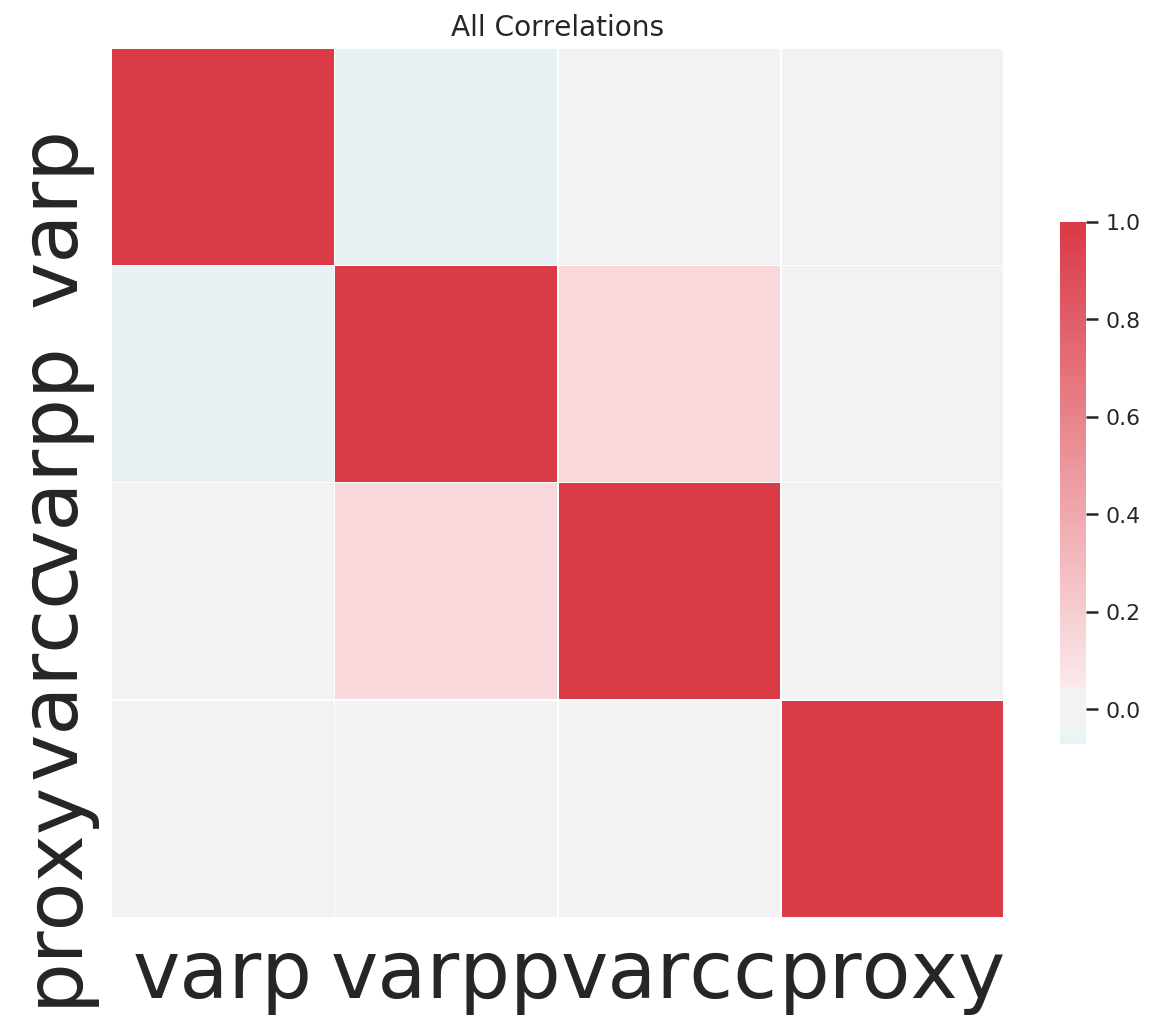

In [20]:
fs.identify_collinear(correlation_threshold=0.8)
fs.plot_collinear(plot_all=True)

Между varpp и varcc есть небольшая допустимая корреляция, varp с остальными кореллирует мало.


In [21]:
from sklearn.model_selection import train_test_split

drop_size = .95
train_s, _, label_s, _ = train_test_split(train, label, test_size=drop_size, stratify=label, random_state=42)
#df_sample = df.sample(frac=.02)
#train = df_sample.drop(columns=df.columns[-3:]).drop(columns='date_time')
#label = df_sample['conversions']
train_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 107853 to 295595
Data columns (total 22 columns):
banner_id        50000 non-null object
advertiser_id    50000 non-null object
offer_id         19785 non-null object
zone_id          50000 non-null object
affiliate_id     50000 non-null object
geo              49996 non-null object
region_code      50000 non-null object
city_code        50000 non-null object
varp             50000 non-null float64
os_type          50000 non-null object
os               50000 non-null object
os_version       50000 non-null object
device_type      50000 non-null object
device           50000 non-null object
browser          50000 non-null object
lang             50000 non-null object
varpp            50000 non-null float64
varcc            50000 non-null float64
isp              50000 non-null object
mobile_isp       50000 non-null object
proxy            50000 non-null int64
netspeed         50000 non-null object
dtypes: float64(3), int64

In [23]:
# train_s = pd.get_dummies(train_s, columns=categorical_without_nans)
# train_s = pd.get_dummies(train_s, columns=categorical_with_nans, dummy_na=True)
# train_s.info()

In [24]:
fs = FeatureSelector(data=train_s, labels=label_s)

fs.identify_all(selection_params = {'missing_threshold': 0.6,    
                                    'correlation_threshold': 0.75, 
                                    'task': 'classification',    
                                    'eval_metric': 'auc', 
                                    'cumulative_importance': 0.6,
                                    'early_stopping': True})

1 features with greater than 0.60 missing values.

0 features with a single unique value.

0 features with a correlation magnitude greater than 0.75.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[17]	valid_0's auc: 0.792704
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[5]	valid_0's auc: 0.745199
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[105]	valid_0's auc: 0.767217
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[76]	valid_0's auc: 0.779479
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[78]	valid_0's auc: 0.790685
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[32]	valid_0's auc: 0.812606
Training until validation scores don't improve for 10

In [25]:
fs.feature_importances

,feature,importance,normalized_importance,cumulative_importance
0,varpp,128.40,0.06,0.06
1,varcc,50.40,0.02,0.08
2,os_version_win7,28.50,0.01,0.09
3,zone_id_13732852.0,25.20,0.01,0.10
4,banner_id_23012989.0,23.60,0.01,0.11
5,netspeed_BROADBAND,22.10,0.01,0.12
6,mobile_isp_0.0,22.00,0.01,0.13
7,browser_chrome,20.70,0.01,0.14
8,device_type_phone,20.20,0.01,0.15
9,lang_en,19.60,0.01,0.16


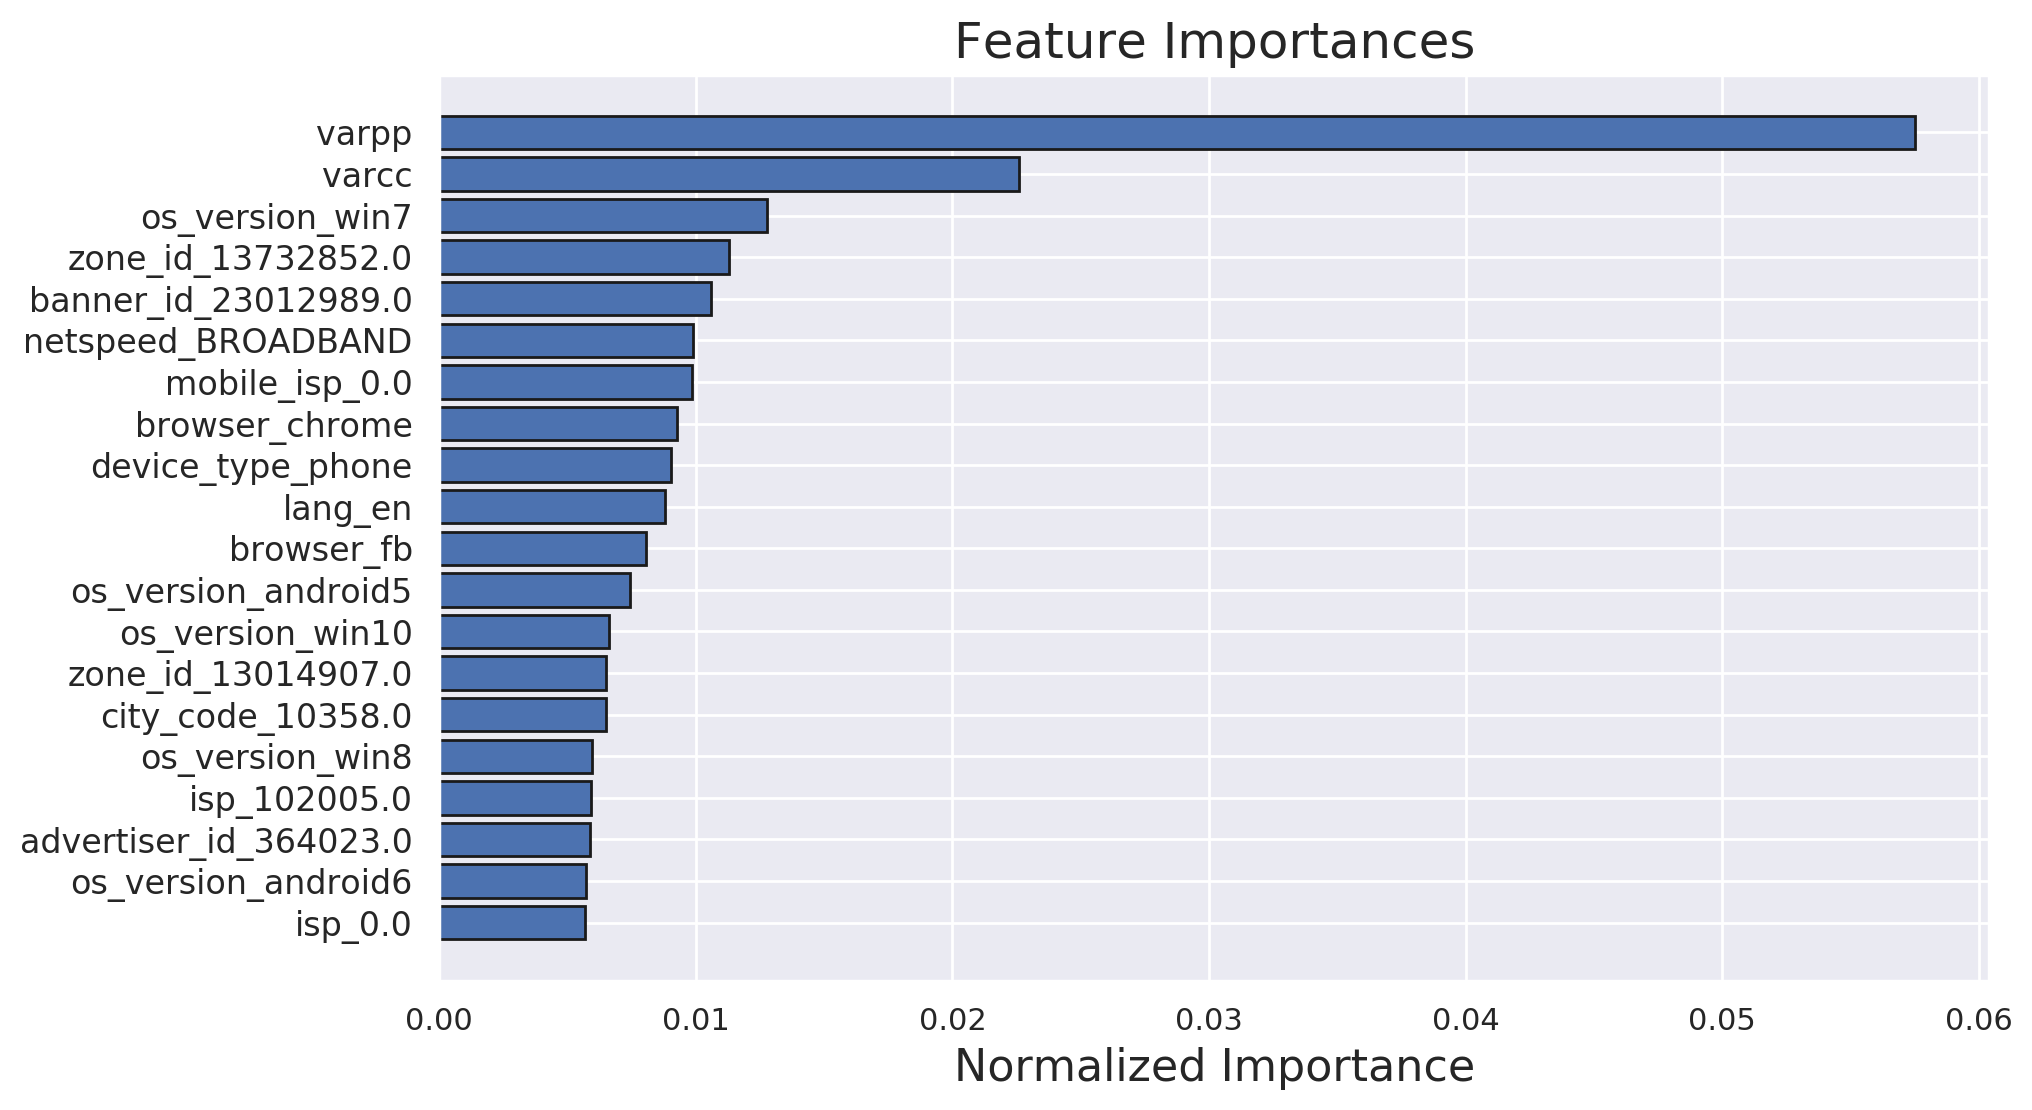

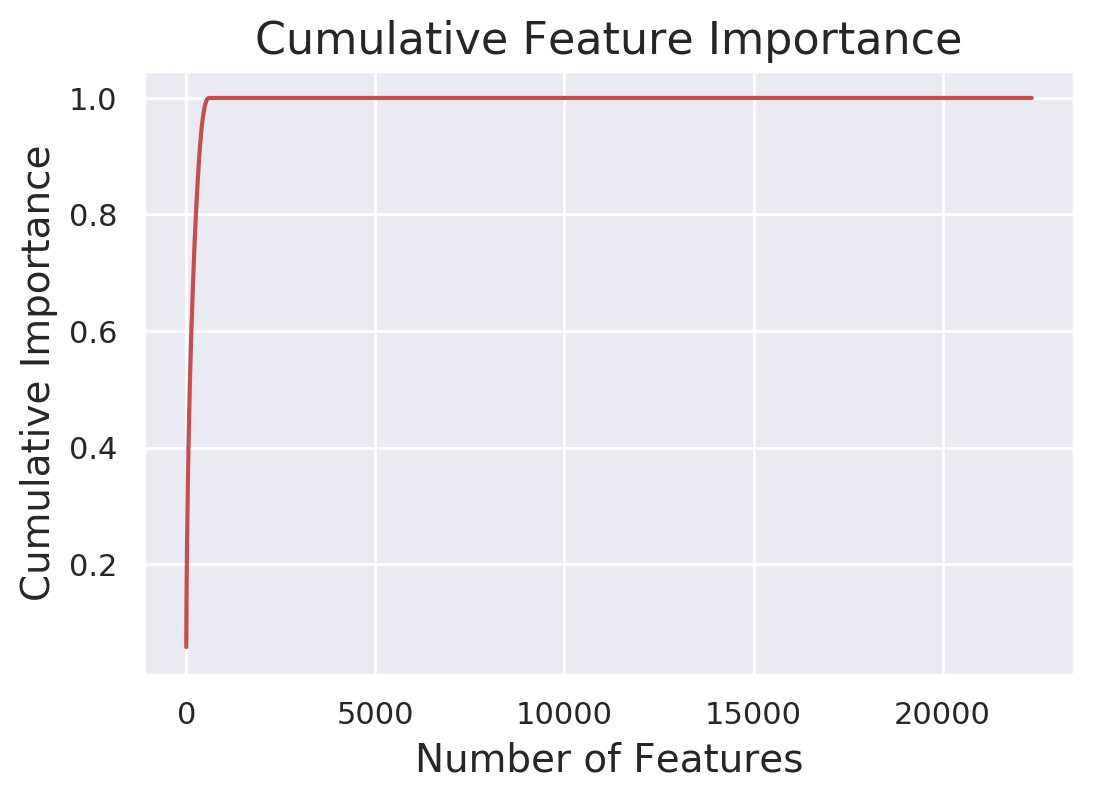

In [108]:
fs.plot_feature_importances(plot_n=20)

## Восстановим изначальные признаки из OHE-производных

In [145]:
categorical_columns = categorical_without_nans.append(categorical_with_nans)
support = pd.DataFrame([], columns=['features', 'nonzero', 'zero', 'ratio'])

for idx, column in enumerate(categorical_columns):
    filtered_one_hoted = fs.feature_importances.feature.str.contains(column)  # regex doesn't work
    temp = fs.feature_importances[filtered_one_hoted]
    non_zero_importance = (temp['importance'] != 0).sum()
    zero_importance = (temp['importance'] == 0).sum()
    support.loc[idx] = column, non_zero_importance, zero_importance,\
    non_zero_importance/(non_zero_importance + zero_importance)

support.sort_values(by='ratio', ascending=False)

,features,nonzero,zero,ratio
13,browser,11,2,0.85
17,netspeed,7,2,0.78
3,zone_id,74,26,0.74
11,device_type,3,2,0.60
12,device,6,6,0.50
9,os,19,21,0.47
10,os_version,13,15,0.46
8,os_type,1,2,0.33
14,lang,17,39,0.30
5,geo,39,138,0.22


In [26]:
train_filtered_feats  = fs.remove(methods='all', keep_one_hot=False)

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 22353 features including one-hot features.


In [27]:
train_filtered_feats.columns.shape

(20,)

In [28]:
train.columns.drop(train_filtered_feats)

Index(['offer_id', 'proxy'], dtype='object')

__Замечания__:
* offer_id ожидаемо выпал из списка важных признаков.
* proxy - сомнительный признак для исключения.
---
Почему:
    Признак proxy сам по себе является не слишком показательным, а вот его инверсивный вариант, возможно, будет важным. Если ввести индикатор *no_proxy*, то он будет указывать на нашу уверенность в достоверности информации об интернет-подключении(провайдер и т.д.) и производных из него - например, гео-признаков. 

### Проверим количественные признаки.

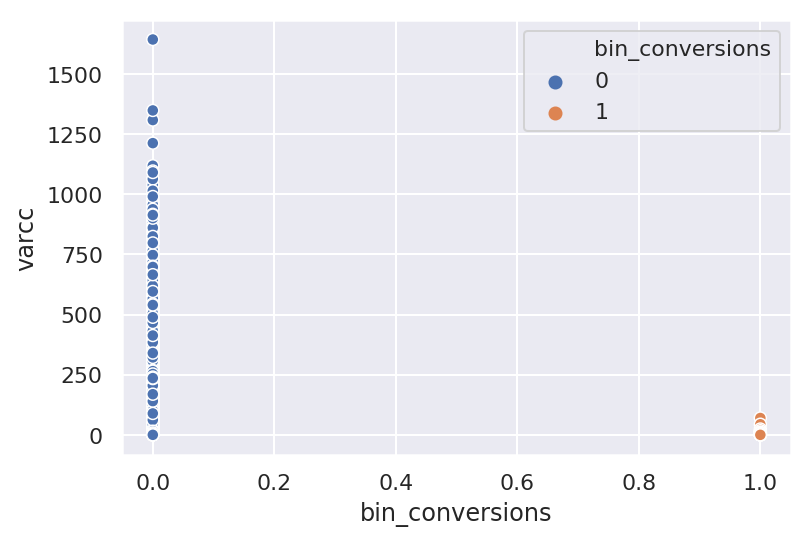

In [29]:
sns.scatterplot(x=df.bin_conversions, y=df.varcc, hue=df.bin_conversions)

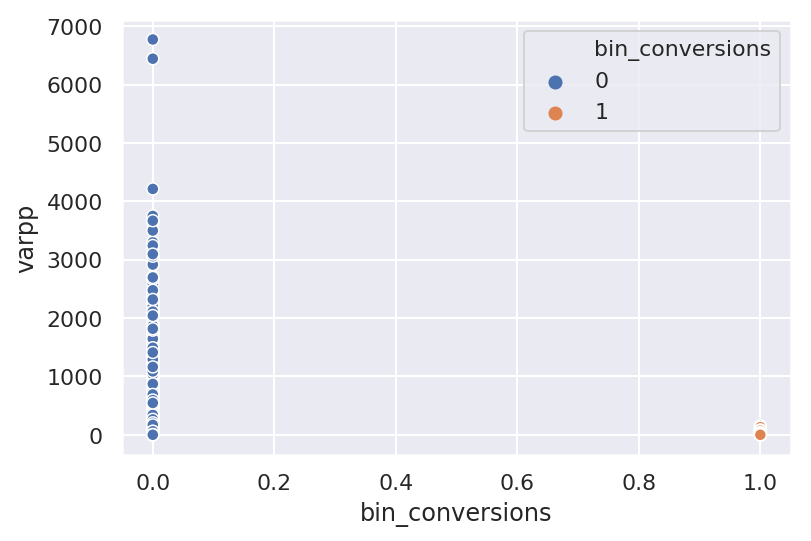

In [30]:
sns.scatterplot(x=df.bin_conversions, y=df.varpp, hue=df.bin_conversions)

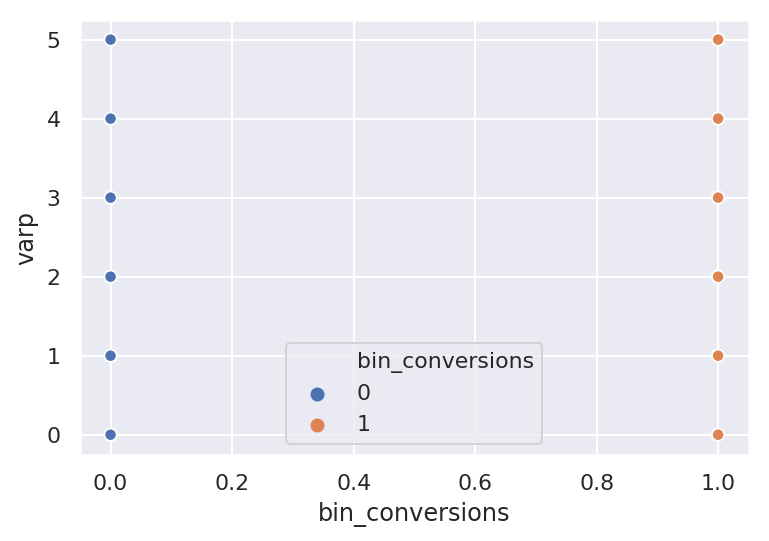

In [31]:
sns.scatterplot(x=df.bin_conversions, y=df.varp, hue=df.bin_conversions)

### У переменных varcc и varcc для каждого значения зависимой переменной есть уникальные значения, а у varp таких значений нет.
Следовательно, она может быть нерелевантной.

In [44]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_num = scaler.fit_transform(df[['varcc', 'varp', 'varpp']].values)
y = df.bin_conversions.values

f_scores, p_scores = f_classif(X_num, y)

In [45]:
# score of F-test
print('{}'.format('\n'.join(str(x) for x in zip(f_scores, ['varcc', 'varp', 'varpp']))))

(69.82414405659642, 'varcc')
(4.6355914365105135e-05, 'varp')
(61.0591045099958, 'varpp')


In [46]:
# p-value score
print('{}'.format('\n'.join(str(x) for x in zip(p_scores, ['varcc', 'varp', 'varpp']))))

(6.491573163165705e-17, 'varcc')
(0.9945676307643212, 'varp')
(5.544011267877957e-15, 'varpp')


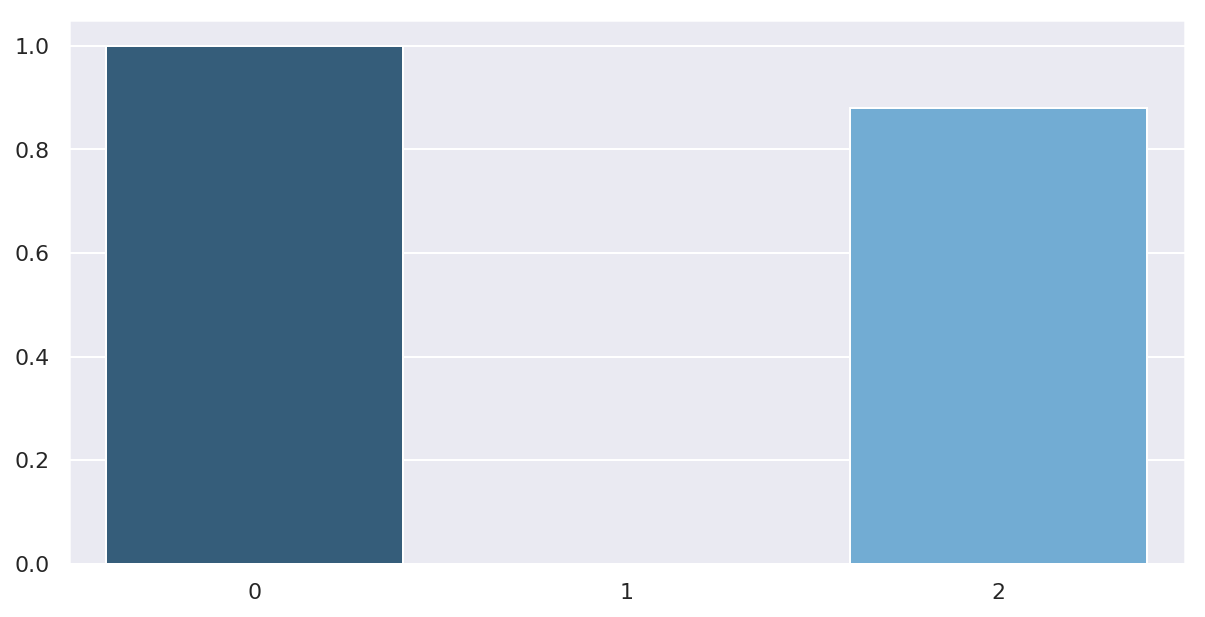

In [67]:
from sklearn.feature_selection import SelectPercentile

X_indices = np.arange(X_num.shape[-1])

selector = SelectPercentile(f_classif, percentile=10)
selector.fit(X_num, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.barplot(X_indices, scores, palette="Blues_d", saturation=1, ax=ax);

### Согласно тесту Фишера, 'varp' значимости не имеет. 

/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axi

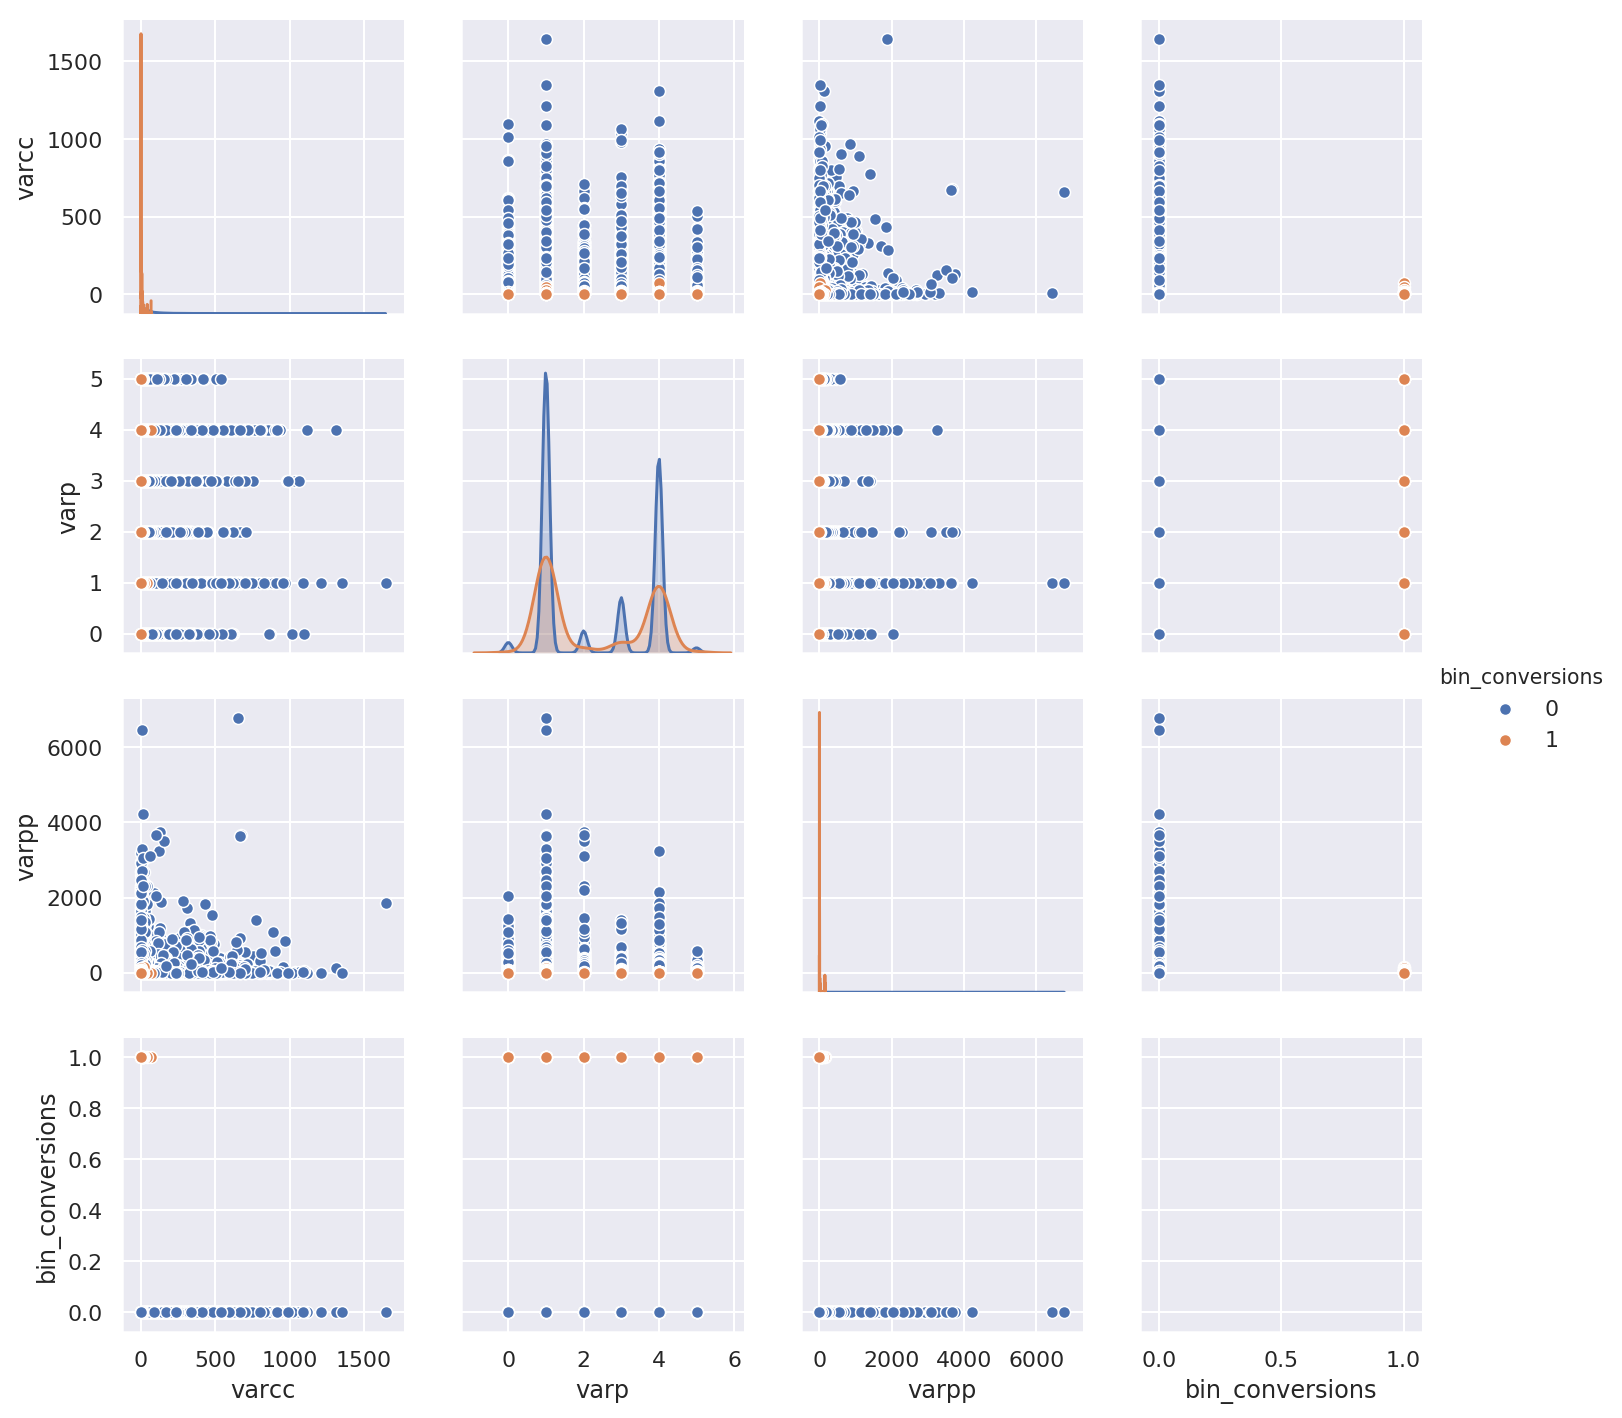

In [69]:
sns.pairplot(df[['varcc', 'varp', 'varpp', 'bin_conversions']], 
        hue="bin_conversions", diag_kind="kde")

In [36]:
train.drop(columns=['offer_id', 'varp'], inplace=True)

for col in ['geo', 'os_type', 'os', 'os_version', 'device_type', 'device', 'browser', 'netspeed', 'lang']:
    train[col], _ = train[col].factorize()

In [41]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(train.values, label.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	2
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1
Iteration: 	99 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	1


/home/dartsirkidman/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=123, n_jobs=-1, oob_score=False,
            random_state=<mtrand.RandomState object at 0x7f625307d240>,
            verbose=0, warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x7f625307d240>,
     two_step=True, verbose=2)

In [42]:
feature_selected = ', '.join(train.columns[feat_selector.support_].tolist())
print(f'selected features: {feature_selected}')

selected features: banner_id, advertiser_id, zone_id, affiliate_id, geo, region_code, city_code, os, os_version, device_type, device, browser, lang, varpp, varcc, isp, mobile_isp, netspeed


In [153]:
set(train.columns.tolist()) - set(train.columns[feat_selector.support_].tolist())

{'os_type', 'proxy'}

In [43]:
pd.Series(data={k: v for k,v in zip(train.columns.values.tolist(), feat_selector.ranking_)})

banner_id        1
advertiser_id    1
zone_id          1
affiliate_id     1
geo              1
region_code      1
city_code        1
os_type          2
os               1
os_version       1
device_type      1
device           1
browser          1
lang             1
varpp            1
varcc            1
isp              1
mobile_isp       1
proxy            3
netspeed         1
dtype: int64

In [266]:
X = train_s.drop(columns=['offer_id', 'varp'])


In [342]:
X_train, X_test, y_train, y_test = train_test_split(train_s, label_s, test_size=.5,\
                                                    random_state=1337, stratify=label_s)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

for col in X_test.columns:
    values = X_test[col].isin(X_train[col])
    y_test = y_test[values]
    X_test = X_test[values]

In [344]:
%%time
X_train = pd.get_dummies(X_train, columns=categorical_with_nans, dummy_na=True)
X_train = pd.get_dummies(X_train, columns=categorical_without_nans)

X_test = pd.get_dummies(X_test, columns=categorical_with_nans, dummy_na=True)
X_test = pd.get_dummies(X_test, columns=categorical_without_nans)

CPU times: user 5.15 s, sys: 844 ms, total: 6 s
Wall time: 5.99 s


In [345]:
dict_assign = {k: 0 for k in X_train.columns.drop(X_test.columns)}
X_test = X_test.assign(**pd.DataFrame(dict_assign, index=X_test.index))

In [349]:
X_train.shape, X_test.shape

((25000, 16177), (7378, 16177))

In [346]:
# add no_proxy col

X_train['no_proxy'] = np.abs(~X_train.proxy)
X_test['no_proxy'] = np.abs(~X_test.proxy)

In [347]:
X_train[['proxy', 'no_proxy']].head()

,proxy,no_proxy
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [244]:
import xlearn as xl
from scipy.stats import wilcoxon
from sklearn.metrics import roc_auc_score

In [247]:
fm1 = xl.FMModel(task='binary', init=.1, epoch=50, lr=.2, reg_lambda=.002, metric='auc')
fm2 = xl.FMModel(task='binary', init=.1, epoch=50, lr=.2, reg_lambda=.002, metric='auc')

In [350]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1,\
                                                    random_state=42, stratify=y_train)

In [254]:
# with proxy
fm1.fit(X_train.drop(columns='no_proxy'), y_train,
                 eval_set=[X_val.drop(columns='no_proxy'), y_val],
                 is_lock_free=False)


# with no_proxy
fm2.fit(X_train.drop(columns='proxy'), y_train,
                 eval_set=[X_val.drop(columns='proxy'), y_val],
                 is_lock_free=False)

In [262]:
a = []
b = []

for i in range(30):
    X_test_sample, _, y_ts, _ = train_test_split(X_test, y_test, test_size=.8, stratify=y_test)
    a.append( roc_auc_score( y_ts, fm1.predict(X_test_sample.drop(columns='no_proxy')) ) )
    b.append( roc_auc_score( y_ts, fm2.predict(X_test_sample.drop(columns='proxy')) ) )
wilcoxon(a, b)

WilcoxonResult(statistic=93.0, pvalue=0.0041140307793227126)

Есть некоторая значимость для замены proxy на no_proxy.

In [351]:
X_train.drop(columns='proxy', inplace=True)
X_val.drop(columns='proxy', inplace=True)
X_test.drop(columns='proxy', inplace=True)

Сделаем такой же тест для некоторых признаков, которые ранее имели малый вес в feature_importances.

In [352]:
features_to_check = ['city_code', 'banner_id', 'isp', 'affiliate_id', \
                     'mobile_isp', 'advertiser_id', 'region_code']

In [353]:
scores = {}

for column in tqdm(features_to_check, desc='feature'):
    to_drop = X_train.columns.str.contains(column)
    to_drop = X_train.columns[to_drop]
    
    # include low-important column
    fm1.fit(X_train, y_train,
                 eval_set=[X_val, y_val],
                 is_lock_free=False)


    # drop low-important
    fm2.fit(X_train.drop(columns=to_drop), y_train,
                 eval_set=[X_val.drop(columns=to_drop), y_val],
                 is_lock_free=False)
    a = []
    b = []

    for i in tqdm(range(30), desc='dummy_cv'):
        X_test_sample, _, y_ts, _ = train_test_split(X_test, y_test, test_size=.8, stratify=y_test)
        a.append( roc_auc_score( y_ts, fm1.predict(X_test_sample) ) )
        b.append( roc_auc_score( y_ts, fm2.predict(X_test_sample.drop(columns=to_drop)) ) )
    score = wilcoxon(a, b)
    scores[column] = score

In [367]:
pd.options.display.float_format = '{:.5f}'.format

pd.DataFrame([[value.statistic, value.pvalue] for value in scores.values()],\
             index=scores.keys(), columns=['statistic', 'p-value'])

,statistic,p-value
city_code,161.00000,0.14139
banner_id,116.00000,0.01656
isp,172.00000,0.21336
affiliate_id,129.50000,0.03411
mobile_isp,93.00000,0.00411
advertiser_id,12.00000,0.00001
region_code,127.00000,0.03001


Больше всего подозрений по итогу тестов вызывает advertiser_id.

## Conclusions
    1) date_time в изначальном формате смысла для классификации не несет.
    2) offer_id нужно или убрать, или заполнить.
    3) varp переменная является незначимой.
    4) proxy нужно заменить на no_proxy.
    5) os_type может быть избыточным.
    6) с feature_importances для OHE-предикторов можно ознакомиться в отдельном файле fs_importances.csv
    7) По итогам тестов малый вклад вносят advertiser_id и mobile_isp, но это само по себе сомнительно логически.